In [1]:

%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import os
print(os.getpid())
%cd ../../

import pylib.mix as mix
import pylib.measurement as mse
import pylib.Chebyschev_coefs as ch
colors_ = ["blue", "red", "green", "gray", "black"]
cmap_two_signs_= 'coolwarm'
cmap_two_signs_= 'Blues'
path_save_ = "./jupyter-notebooks/NL/results/"

9283
/media/work/docs/codes/QuCF/scripts-py


In [2]:
for i in range(30):
    plt.close()

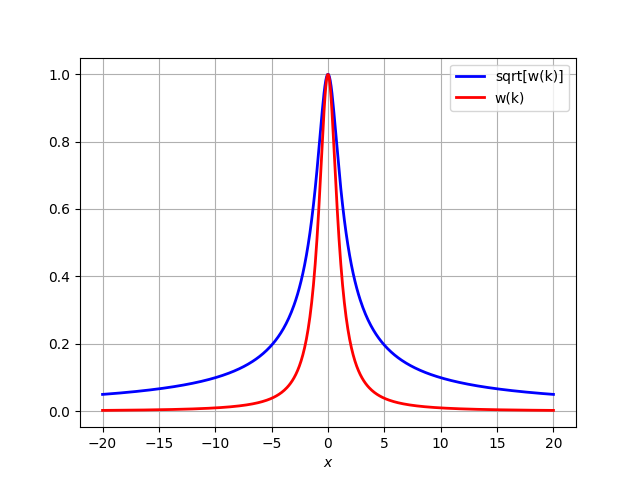

In [4]:
# -------------------------------------------------------------------
# --- Plot weights --- 
# -------------------------------------------------------------------
mix.reload_module(mix)

def func_sqrt_weights(k):
    return np.sqrt(1./ (1 + k**2))

def func_weights(k):
    return 1./ (1 + k**2)

def plot_save(k_max, nk, flag_save):
    Nk = 1 << nk

    # k-grid:
    k = np.linspace(-k_max, k_max, Nk)

    # --- Plotting ---
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(
        k, func_sqrt_weights(k), 
        color='b', linewidth = 2, linestyle='-',  label = "sqrt[w(k)]"
    )
    ax.plot(
        k, func_weights(k), 
        color='r', linewidth = 2, linestyle='-',  label = "w(k)"
    )
    plt.xlabel('$x$')
    ax.legend()
    plt.grid(True)
    plt.show()
    
    # --- Save the data ---
    if flag_save:
        fname = "weights_profs_k{:d}.dat".format(k_max)
        full_name = path_save_ + "/" + fname
        mix.save_dat_plot_1d_file(full_name, k, func_weights(k))
        
        fname = "weights_sqrt_profs_k{:d}.dat".format(k_max)
        full_name = path_save_ + "/" + fname
        mix.save_dat_plot_1d_file(full_name, k, func_sqrt_weights(k))
    
    return
# ------------------------------------------------------------
flag_save = False
k_max, nk = 20, 9
plot_save(k_max, nk, flag_save)

Function parameter:		 1.000e+01
Chosen function, parity:	 LCHS-weights-2, 0

Minimization method is used.
Computation status:  4.996335600819802e-08

x[0] =  -0.9999922893814707
x[-1] =  0.9999922893814706
Chosen polynomial's degree:	 100
Number of coefficients:		 50
max. abs. error: 4.746e-05


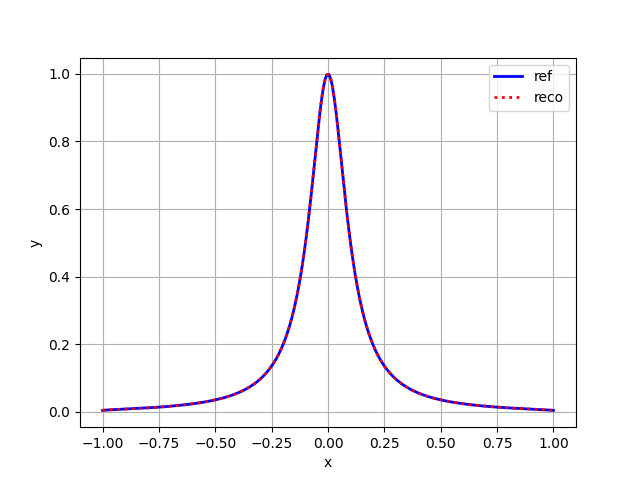

write angles to:
 ./tools/QSVT-angles/LCHS-weights-2/coefs//LCHS-weights-2_10_eps4.hdf5


In [12]:
# --------------------------------------------------------------
# --- Compute Chebyschev coefficients for the weights ---
# --------------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(ch)

sel_method = 0

# id_fun = 4 # 1/sqrt(1+k^2);
id_fun = 41 # 1/(1+k^2);

par1   = 10 # kmax;
Nd = 100 # degree of the approximating polynomial;

# --- Computation ---
oo_ch_ = ch.Ch_()
oo_ch_.choose_method(sel_method)
oo_ch_.choose_func(id_fun, par1)
oo_ch_.compute_Ch(Nd)
oo_ch_.plot_reconstructed_function()
oo_ch_.save_coefficients()

Reading the file ../QuCF/simulations/compute-LCHS-weights//weights_OUTPUT.hdf5...
Name of the simulation is weights
Simulation has been performed  01-29-2024 18:41:59

kmax: 20.0
nk: 10
succ. prob.: 2.729e-01
max. abs. diff: 1.456e-07


<IPython.core.display.Javascript object>


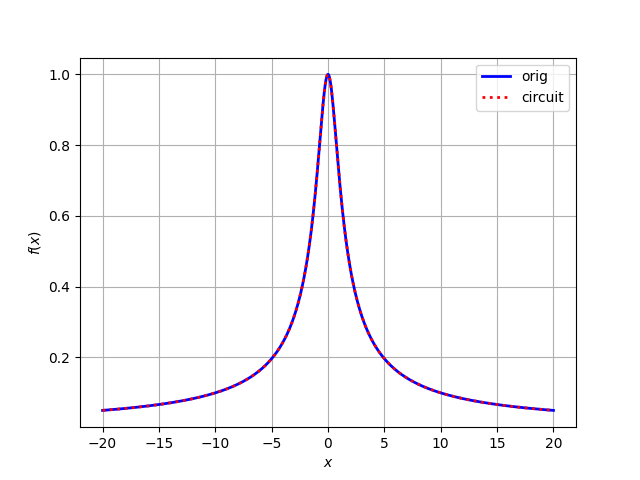

In [8]:
# --------------------------------------------------------------
# --- Plot the results from the QSVT LCHS weights simulation ---
# --------------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(mse)

def read_QSVT_profile():
    om = mse.MeasOracle__(True)

    om.path_ = "../QuCF/simulations/compute-LCHS-weights/"
    om.pname_ = "weights"
    om.open()
    om.read_qsvt()

    # read k-max
    k_max_c = om.dd_["weights"]["par"]

    # form k-grid
    nk_c = om.dd_["regs"]["rk"]
    Nk_c = 1 << nk_c
    k_grid_c = np.linspace(-1., 1., Nk_c);

    # output state
    # om.set_zero_ancillae_work_states(0)
    # weights_c = om.get_var_x({}, "rk")

    # --- read the weights computed by QSVT ---
    om.set_work_states(0)
    weights_c = om.get_var_x({"a_be": 0, "a_qsvt": 0, "aref": 0}, "rk")

    # --- normalization factor ---
    qsvt_rescaling = om.dd_["weights"]["rescaling_factor"]
    Hadamart_norm_factor = 2**(nk_c/2) # the rescaling factor appears to the initialization circuit;
    coef_norm = Hadamart_norm_factor / qsvt_rescaling

    # --- reference profile ---
    k = np.linspace(-k_max_c, k_max_c, Nk_c)
    y_ref = np.sqrt(1/(1 + k**2))

    # --- Compute the success probability ---
    succ_prob = np.sum(np.abs(weights_c)**2)
    print()
    print("kmax: {:0.1f}".format(k_max_c))
    print("nk: {:d}".format(nk_c))
    print("succ. prob.: {:0.3e}".format(succ_prob))
    
    # --- Absolute difference ---
    max_abs_diff = np.max(np.abs(y_ref - (-coef_norm * weights_c.real)))
    print("max. abs. diff: {:0.3e}".format(max_abs_diff))

    # --- Plot the results ---
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(
        k, y_ref, 
        color='b', linewidth = 2, linestyle='-',  
        label = "orig"
    )
    ax.plot(
        k, -coef_norm * weights_c.real, 
        color='r', linewidth = 2, linestyle=':',  
        label = "circuit"
    )
    plt.xlabel('$x$')
    plt.ylabel("$f(x)$")
    ax.legend()
    plt.grid(True)
    plt.show()
    
    return
# ---------------------------------------------------------------------------
read_QSVT_profile()

In [3]:
# ---------------------------------------------------------------------------------------
# --- Scaling of the QSVT success probability versus kmax and nk                      ---
# ---------------------------------------------------------------------------------------
mix.reload_module(mix)

def scaling_success_probability():
    def save_data(kmax, ss_prob):
        mix.save_dat_plot_1d_file(
            path_save_ + "/scan_weights_ss_prob.dat", 
            kmax, 
            ss_prob
        )
        return
    # -------------------------------------------------------------------------

    kmax_s  = [10,        20,        30,        40,        50,        60]
    ss_prob = [3.745e-01, 2.701e-01, 2.240e-01, 1.945e-01, 1.743e-01, 1.593e-01]
    ss_prob = np.array(ss_prob)**2
    save_data(kmax_s, ss_prob)
    return
# --------------------------------------------------------------------------
scaling_success_probability()

write data to a file: ./jupyter-notebooks/NL/results//scan_weights_ss_prob.dat


In [70]:
# ---------------------------------------------------------------------------------------
# --- Scaling of the number of Chebyschev coefficients necessary to implement weights ---
# --- with the desired precision for the chosen kmax.                                 ---
# ---------------------------------------------------------------------------------------
mix.reload_module(mix)

def scaling_Nd_eps():
    def save_data_eps(Nd, eps, kmax_in):
        N_angles = 2 * (np.array(Nd)/2) - 1
        log_eps = -np.log10(eps) 

        mix.save_dat_plot_1d_file(
            path_save_ + "/scan_Na_eps_kmax{:d}.dat".format(kmax_in), 
            log_eps, 
            N_angles
        )
        return

    def get_data_eps(Nd, eps):
        N_angles = 2 * (np.array(Nd)/2) - 1
        log_eps = np.log10(eps) 
        return N_angles, log_eps
    # -------------------------------------------------------------------------

    kmax_s = 10
    abs_errors = [2.378e-3, 1.512e-04, 1.178e-04, 6.447e-05, 4.188e-05, 2.514e-05, 1.120e-05]
    Nd_pol     = [      50,       120,       150,       250,       350,       500,      1000]
    save_data_eps(Nd_pol, abs_errors, kmax_s)


    kmax_s = 20
    abs_errors = [2.242e-03, 1.555e-04,  2.575e-05, 1.479e-05, 1.263e-05, 5.628e-06]
    Nd_pol     = [      100,       150,        300,       450,       500,      1000]
    save_data_eps(Nd_pol, abs_errors, kmax_s)


    kmax_s = 40
    abs_errors = [2.185e-03, 1.507e-04, 1.085e-05, 4.793e-06, 3.541e-06, 2.817e-06]
    Nd_pol     = [      200,       300,       400,       600,       800,      1000]
    save_data_eps(Nd_pol, abs_errors, kmax_s)


    kmax_s = 60
    abs_errors = [2.165e-03, 1.495e-04, 1.079e-05, 2.361e-06, 1.878e-06]
    Nd_pol     = [      300,       450,       600,       800,      1000]
    save_data_eps(Nd_pol, abs_errors, kmax_s)


    kmax_s = 80
    abs_errors = [2.156e-03, 1.489e-04, 1.075e-05, 1.405e-06]
    Nd_pol     = [      400,       600,       800,      1000]
    save_data_eps(Nd_pol, abs_errors, kmax_s)
    
    return
# --------------------------------------------------------------------------
scaling_Nd_eps()

write data to a file: ./jupyter-notebooks/NL/results/scan_Na_eps_kmax10.dat
write data to a file: ./jupyter-notebooks/NL/results/scan_Na_eps_kmax20.dat
write data to a file: ./jupyter-notebooks/NL/results/scan_Na_eps_kmax40.dat
write data to a file: ./jupyter-notebooks/NL/results/scan_Na_eps_kmax60.dat
write data to a file: ./jupyter-notebooks/NL/results/scan_Na_eps_kmax80.dat


In [18]:
# ---------------------------------------------------------
# --- Compute angles for circuit ---
# ---------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(mse)
from scipy.optimize import fsolve

def compute_BE_angles(kmax, nk):
    def compute_corr():
        # !!! Attention !!!
        # the correction angles is computed from a QuCF computation performed
        # without the correcting gates:

        om = mse.MeasOracle__(True)
        om.path_ = "../QuCF/tests/compute-LCHS-weights/"
        om.pname_ = "weights"
        om.open()
        om.set_work_states(0)
        res_k0 = om.get_var_x({"a_be": 0, "rk": 0}, "a_qsvt") 

        def func_to_solve(x):
            aa = res_k0[0]
            aas = res_k0[1]
            return [aa * np.cos(x[0]/2.) - 1j*np.sin(x[0]/2.)*aas - aa / np.sqrt(2.)]

        res = fsolve(func_to_solve, [0.1])

        print("recheck: {:20.3e}".format(func_to_solve(res)[0]))
        print()

        return res[0] 
    # -------------------------------------------------------

    Nk = 1 << nk
    
    # --- for the x-grid ---
    alpha_k0 = - 1.0
    alpha_k1 = np.abs(alpha_k0) * Nk/(Nk - 1)

    print("nk \t{:d}".format(nk))
    print("alpha_k0 \t{:0.12e}".format(alpha_k0))
    print("alpha_k1 \t{:0.12e}".format(alpha_k1))
    
    
#   # --- correction ---
#   alpha_k_corr = compute_corr()
#     print("alpha_k_corr \t{:0.12e}".format(alpha_k_corr))

    del alpha_k0, alpha_k1
# ------------------------------------------------------------------------------------
compute_BE_angles(
    kmax = 10,
    nk = 14
)

nk 	14
alpha_k0 	-1.000000000000e+00
alpha_k1 	1.000061038882e+00
